# Threshold relaxations
> What can our RnaDB tell us about the implications of setting different id thresholds in VSEARCH?

Heree's the rough idea:
* We need ~1000 reads per PTR estimate to be within ~.1 of the true PTR, in expectation
* Sequencing noise disproportionately hurts us at very high ID cutoffs
* One approach to fixing this is to relax the identity cutoff for the final VSEARCH pass
* However, the inference depends on having more distinct sequences than distinct genomes
* Thus, we cannot relax the identity threshold indiscriminately

We can try to replace the sequence-sharing matrix with an identity matrix:

How does the strict triangle inequality $D(X,Y) = D(X,Z) + D(Z,Y)$ for MRCA Z help us?




Algorithm sketch:
* For sequences, generate edit-distance matrix:
    * Use `Levenshtein` package, probably.
    * ANI = (max sequence length - edit distance) / max sequence length (?)
* Re-generate gene2seq matrix:
    * Old way: start with a set union of sequences, create matrix mapping
    entries to sequences using db
    * New way:
        * Start with an ANI matrix
        * Create a graph $G$ by setting $A_{ij} = 1$ if $ANI(S_i,S_j) > t$ and
        0 otherwise
        * Each connected component of $G$ is a sequence bin
            * How can we collapse a square adjacency matrix into a connected
            component membership matrix?
            * Let $G_C$ be the connected component matrix
        * Subsitute connected component matrix $G_C$ and proceed as normal
    * Unresolved issues:
        * Need to filter database again to ensure that connected components
        still have enough degrees of freedom / throw away newly underconstrained
        sequences.
        * Is there a way to use the adjacency matrix to do filtering as well?
            * Something like: for what genomes do all genes end up in the same
            connected component?
            * Don't forget that we also remove ``free'' sequences (a single
            organism can set any count).
* Downstream analyses:
    * What is the maximum ANI cutoff we can have for different organisms?
        * Do we need an adaptive threshold?
        * In general, how many reads do we expect to be able to salvage this
        way?


# Compute edit distances

In [55]:
import sys
sys.path.append('/home/phil/aptr')
%load_ext autoreload
%autoreload 2

In [3]:
import Levenshtein
from multiprocessing import Pool
from functools import partial

In [42]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

In [15]:
seqs = pd.read_table("../data/allSSU.tsv")["feature.na_sequence"].unique()
seqs = list([str(x) for x in seqs])
n = len(seqs)

In [63]:
def matrix_row(i):
    s1 = seqs[i]
    return [Levenshtein.distance(s1, s2) for s2 in seqs[i+1:]]


def compute_dists_parallel(seqs):
    n = len(seqs)
    # Compute the Levenshtein distance matrix (parallelized)

    # Parallelized call to memoized distance
    with Pool(12) as p:
        distance = list(tqdm(p.imap(matrix_row, range(n)), total=n, desc=f"Computing distance matrix {n}x{n}"))
    
    # Fill in the distance matrix
    out = np.array([[0]*(n - len(x)) + x for x in distance])
    out += out.T
    return out

In [39]:
np_dist = np.array([[0]*(n - len(x)) + x for x in distance])
# Set the lower triangle to the upper triangle
np_dist = np_dist + np_dist.T

# Save the distance matrix
np.save("../data/levenshtein_distance_matrix.npy", np_dist)

# Explore distribution of edit distances

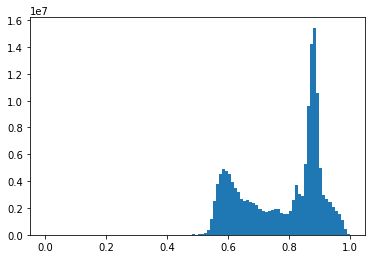

In [44]:
# Basic histogram first
sims = 1 - (np_dist / np_dist.max())
plt.hist(sims.flatten(), bins=100)
plt.show()

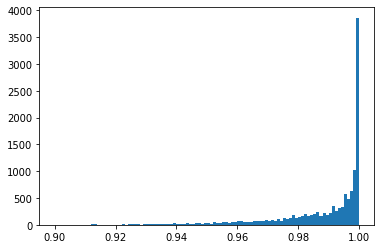

In [52]:
# Let's look at the max similarity

sims_offdiag = sims - np.diag(np.diag(sims))
plt.hist(sims_offdiag.max(axis=0), bins=100, range=(0.9, 1))
plt.show()

## For V4 region

In [56]:
from src.new_filter import _trim_primers

In [61]:
v4s = [_trim_primers(x, left="tgccagcmgccgcggtaa", right="attagawacccbdgtagtcc") for x in seqs]

In [64]:
dists_v4 = compute_dists_parallel(v4s)

/home/phil/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


Computing distance matrix 12628x12628:   0%|          | 0/12628 [00:00<?, ?it/s]

AttributeError: Can't pickle local object 'compute_dists_parallel.<locals>.matrix_row'

In [67]:
v4s

['tgccagcagccgcggtaatacgtaggtggcaagcgttgtccggaattattgggcgtaaagcgcgcgcaggcggtcctttaagtctgatgtgaaagcccacggctcaaccgtggagggtcattggaaactgggggacttgagtacagaagaggaaagcggaattccacgtgtagcggtgaaatgcgtagagatgtggaggaacaccagtggcgaaggcggctttctggtctgtaactgacgctgaggcgcgaaagcgtggggagcaaacaggattagataccctggtagtcc',
 '',
 'tgccagcagccgcggtaatacgtagggcgcaagcgttatccggaattattgggcgtaaagagctcgtaggcggtttgtcgcgtctgccgtgaaagtccggggctcaaccccggatctgcggtgggtacgggcagactagagtgatgtaggggagactggaattcctggtgtagcggtgaaatgcgcagatatcaggaggaacaccgatggcgaaggcaggtctctgggcattaactgacgctgaggagcgaaagcatggggagcgaacaggattagataccctggtagtcc',
 'tgccagcagccgcggtaatacgtagggggcaagcgttgtccggaattattgggcgtaaagcgcgcgcaggcggtcatttaagtctggtgtttaatcccggggctcaaccccgggtcgcactggaaactgggtgacttgagtacagaagaggagagtggaattccacgtgtagcggtgaaatgcgtagatatgtggaggaacaccagtggcgaaggcgactctctgggctgtaactgacgctgaggcgcgaaagcgtggggagcaaacaggattagataccctggtagtcc',
 'tgccagcagccgcggtaatacgtagggggcaagcgttgtccggaattattgggcgtaaagcgcgcgcaggcggtcatttaagtctggtgtttaatcccggggctca